In [1]:
import time
import os
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"    
import tensorflow as tf
import matplotlib.pyplot as plt
import MetaTrader5 as mt5
import pandas as pd    
import numpy as np
import datetime
import math
from IPython.display import clear_output
import ta
from collections import deque
import math
from tqdm import tqdm

seq_len = 550
commission = 10/100000
account = int(150475)
mt5.initialize()
authorized=mt5.login(account)
mt5.account_info(), mt5.positions_get()

(AccountInfo(login=150475, trade_mode=0, leverage=50, limit_orders=0, margin_so_mode=0, trade_allowed=True, trade_expert=True, margin_mode=2, currency_digits=2, fifo_close=False, balance=1000.0, credit=0.0, profit=0.0, equity=1000.0, margin=0.0, margin_free=1000.0, margin_level=0.0, margin_so_call=100.0, margin_so_so=70.0, margin_initial=0.0, margin_maintenance=0.0, assets=0.0, liabilities=0.0, commission_blocked=0.0, name='Marvin Eckhardt', server='Osprey-Demo', currency='USD', company='Osprey Ltd'),
 ())

In [2]:
class candle_class:
  pass
    
class manager:
    candles = []
    def __init__(self, model):
        self.candles = []
        self.model = model
        self.position = 0
        self.current_win = 0
        self.win = 0
        self.last_balance = 0
        
        self.order_value_constant = 1000
        pass
    
    
    
    def candles_to_dataframe(self, candles):
        o = [x.o for x in candles]
        h = [x.h for x in candles]
        l = [x.l for x in candles]
        c = [x.c for x in candles]
        data = {"Open":o, "High":h, "Low":l, "Close":c}
        df = pd.DataFrame(data)
        return df
    
    def add_new_candle(self, t,o,h,l,c):
            
        new_candle = candle_class()
        new_candle.t = t
        new_candle.o = o
        new_candle.h = h
        new_candle.l = l
        new_candle.c = c
        self.candles.append(new_candle)
        
        if len(self.candles) >= 200:
            
            df = self.candles_to_dataframe(self.candles[-21:])
            sma21_raw = list(ta.trend.SMAIndicator(df["Close"], 21).sma_indicator())[-1]
            
            #df = self.candles_to_dataframe(self.candles[-50:])
            #sma50_raw = list(ta.trend.SMAIndicator(df["Close"], 50).sma_indicator())[-1]
            
            df = self.candles_to_dataframe(self.candles[-200:])
            sma200_raw = list(ta.trend.SMAIndicator(df["Close"], 200).sma_indicator())[-1]
            
            df = self.candles_to_dataframe(self.candles[-14:])
            rsi_14 = list(ta.momentum.RSIIndicator(df["Close"], 14).rsi())[-1] / 50 - 1

            df = self.candles_to_dataframe(self.candles[-200:])
            atr_value = list(ta.volatility.AverageTrueRange(df["High"], df["Low"], df["Close"], 200).average_true_range())[-1]
        
            #df = self.candles_to_dataframe(self.candles[-21:])
            #donchi = ta.volatility.DonchianChannel(df["High"], df["Low"], df["Close"], 21)
            #dh = list(donchi.donchian_channel_hband())[-1]
            #dl = list(donchi.donchian_channel_lband())[-1]
            
            #new_candle.dh = dh
            #new_candle.dl = dl
            new_candle.sma21 = sma21_raw
            #new_candle.sma50 = sma50_raw
            new_candle.sma200 = sma200_raw
            new_candle.rsi14 = rsi_14
            new_candle.atr_value = atr_value
            
            self.candles[-1] = new_candle
            
        if len(self.candles) > seq_len + 200:
            del self.candles[0]
            
        
        if self.position != 0:
          current_price = self.candles[-1].c
          entry = self.entry_price
          diff = (current_price - entry) / entry * self.order_value_constant

          if self.position == 1:
            self.current_win = diff
          if self.position == -1:
            self.current_win = -diff
            
          
        
    def sample_to_x_y(self, sample):
        
                current_close = sample[-1].c

                prev_close = [candle.c for candle in sample]
                prev_high = [candle.h for candle in sample]
                prev_low = [candle.l for candle in sample]
                

                prev_sma21 = [candle.sma21 for candle in sample]
                prev_sma200 = [candle.sma200 for candle in sample]
                
                
                prev_sma21_relative = [(prev_close[o] - prev_sma21[o]) / prev_sma21[o]*100 for o in range(seq_len)]
                prev_sma200_relative = [(prev_close[o] - prev_sma200[o]) / prev_sma200[o]*100 for o in range(seq_len)]

                prev_close_relative = [0] + [(prev_close[o+1] - prev_close[o]) / prev_close[o]*1000 for o in range(seq_len-1)]
                prev_high_relative = [(prev_close[o] - prev_high[o]) / prev_close[o]*1000 for o in range(seq_len)]
                prev_low_relative = [(prev_close[o] - prev_low[o]) / prev_close[o]*1000 for o in range(seq_len)]
                

                
                prev_rsi_14 = [candle.rsi14 for candle in sample]
                

                x = []
                for o in range(len(prev_close)):
                    ts = []

                    
                    ts.append(prev_close_relative[o])
                    ts.append(prev_high_relative[o])
                    ts.append(prev_low_relative[o])
                    
                    ts.append(prev_sma21_relative[o])
                    ts.append(prev_sma200_relative[o])
                    
                    ts.append(prev_rsi_14[o])

                    x.append(ts)

                x = np.array(x)
                return x
        
        
    def get_current_inference_data(self):
        if len(self.candles) == seq_len + 200:
            sample = self.candles[-seq_len:]
            inference_data = self.sample_to_x_y(sample)
            return inference_data
        else:
            return None
        
    
  
    def close(self):
        self.position = 0
        self.win += self.current_win
        self.current_win = 0
      
    def entry(self,price):
        self.entry_price = price
        self.win -= commission * self.order_value_constant

        
    def evaluate(self):
        d = x.get_current_inference_data()
        if type(d) == type(None):
            return None, None, None
        nm = self.model([d.reshape(1,seq_len,6), np.array([self.position, math.tanh(self.current_win)]).reshape(1,2)])[0]
        action = np.argmax(nm)
        price = self.candles[-1].c
        
        if action == 0:
            if self.position != 0:
                self.close()
            pass
    
        if action == 1:
          #short
            if self.position == 1:
                self.close()

            if self.position == -1:
                pass
            else:
                self.position = -1
                self.entry(price)
        
        if action == 2:
            #long
            if self.position == -1:
                self.close()

            if self.position == 1:
                pass
            else:
                self.position = 1
                self.entry(price)
                
        balance = self.win + self.current_win
        change = balance - self.last_balance
        self.last_balance = balance
        


        return nm, change, balance

In [3]:
t = int(time.time()) + 60*60*24
        
prices = mt5.copy_rates_from("EURUSD", mt5.TIMEFRAME_M15, t, 10000)
      
o = [x[1] for x in prices]
h = [x[2] for x in prices]
l = [x[3] for x in prices]
c = [x[4] for x in prices]
        
data = {"Time": [x[0] for x in prices], "Open":o, "High":h, "Low":l, "Close":c}
df = pd.DataFrame(data)

In [4]:


class TransformerBlock(tf.keras.layers.Layer):
    embed_dim = 0
    num_heads = 0
    ff_dim = 0 
    rate=0
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate = rate


        super(TransformerBlock, self).__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(ff_dim, activation="relu"), tf.keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def get_config(self):
        cfg = super().get_config()
        cfg.update()
        cfg.update({
            'embed_dim': self.embed_dim,
            'num_heads': self.num_heads,
            'ff_dim': self.ff_dim,
            'rate': self.rate,
        })
        return cfg  
    def call(self, q, k, training = False):
        attn_output = self.att(q, k)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(q + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

    
def getPositionEncoding(seq_len, d, n=10000):
    P = np.zeros((seq_len, d))
    for k in range(seq_len):
        for i in np.arange(int(d/2)):
            denominator = np.power(n, 2*i/d)
            P[k, 2*i] = np.sin(k/denominator)
            P[k, 2*i+1] = np.cos(k/denominator)
    return P[::]

class Positions(tf.keras.layers.Layer):
    P = []
    d = 0
    seq_len = 0
    def __init__(self, seq_len, d, **kwargs):
        super(Positions, self).__init__()
        self.seq_len = seq_len
        self.d = d
        self.p = getPositionEncoding(seq_len, d)
        

    def call(self, x):
        return x + self.p

    def get_config(self):
        cfg = super().get_config()
        cfg.update()
        cfg.update({
            'p': self.p,
            'seq_len': self.seq_len,
            'd': self.d
        })
        return cfg  



tf.keras.backend.clear_session()
if True:
  inputs_1 = tf.keras.layers.Input(shape = (seq_len, 6))
  inputs_pos = tf.keras.layers.Input(shape = (2))

  x = inputs_1

  x = tf.keras.layers.Dense(16,activation = "relu")(x)
  x = tf.keras.layers.Dense(16,activation = "relu")(x)

  x2 = tf.keras.layers.Conv1D(64, 3,activation="relu", padding="same")(x)
  x = tf.keras.layers.Concatenate()([x2,x])

  x = tf.keras.layers.Dense(32,activation = "relu")(x)

  x2 = tf.keras.layers.Conv1D(512, 21,activation="relu", padding="same")(x)
  x = tf.keras.layers.Concatenate()([x2,x])

  x = tf.keras.layers.Dense(512,activation = "relu")(x)
  x = tf.keras.layers.Dense(256,activation = "relu")(x)
    
  x = tf.keras.layers.LayerNormalization()(x)

  x = Positions(seq_len, x.shape[-1])(x)
  x = TransformerBlock(x.shape[2], 8, 256)(x,x)
  x = TransformerBlock(x.shape[2], 8, 256)(x,x)
  x = TransformerBlock(x.shape[2], 8, 256)(x,x)
  x = TransformerBlock(x.shape[2], 8, 256)(x,x)
  x = TransformerBlock(x.shape[2], 8, 256)(x,x)
  x = TransformerBlock(x.shape[2], 8, 256)(x,x)

  x_end = tf.keras.layers.Lambda(lambda x: x[:,-1])(x)
  x_end = tf.keras.layers.Reshape((1,x.shape[2]))(x_end)
  x = TransformerBlock(x.shape[2], 8, 256)(x_end,x)
  x = tf.keras.layers.Flatten()(x)

  x = tf.keras.layers.Concatenate()([inputs_pos, x])

  x = tf.keras.layers.Dense(512)(x)
  x = tf.keras.layers.LeakyReLU(alpha=0.02)(x)

  x = tf.keras.layers.Dense(512)(x)
  x = tf.keras.layers.LeakyReLU(alpha=0.02)(x)

  x = tf.keras.layers.Dense(512)(x)
  x = tf.keras.layers.LeakyReLU(alpha=0.02)(x)
          
  outputs = tf.keras.layers.Dense(3, activation = "linear", use_bias=False, dtype="float32")(x)
  model = tf.keras.Model([inputs_1,inputs_pos], outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 550, 6)]     0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 550, 16)      112         input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 550, 16)      272         dense[0][0]                      
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 550, 64)      3136        dense_1[0][0]                    
______________________________________________________________________________________________

In [5]:
model.load_weights("dqn_trading_transformer.h5")

In [6]:
x = manager(model)

test = df.iloc[-5000:]

candle_test = []
values = []
x1 = []
x2 = []
x3 = []
nms = []
wins = []
c_wins = []
win=0

try:
    for i in range(len(test)):
        if (i-1)%50 == 0:
            print("\r", i+1,"/",len(test), "   --   ", win, end = "         ")


        candle = test.iloc[i]
        _, o, h, l, c = candle
        x.add_new_candle(i,o,h,l,c)
        nm, c_win, win = x.evaluate()
        cc = x.candles[-1]

        if type(nm) != type(None):

                candle_test.append(cc)

                x1.append(nm[0])
                x2.append(nm[1])
                x3.append(nm[2])
                res = np.argmax(nm)

                nms.append(nm)
                values.append(res)
                c_wins.append(c_win)
                wins.append(win)

    
except KeyboardInterrupt:
    pass

 752 / 5000    --    0            

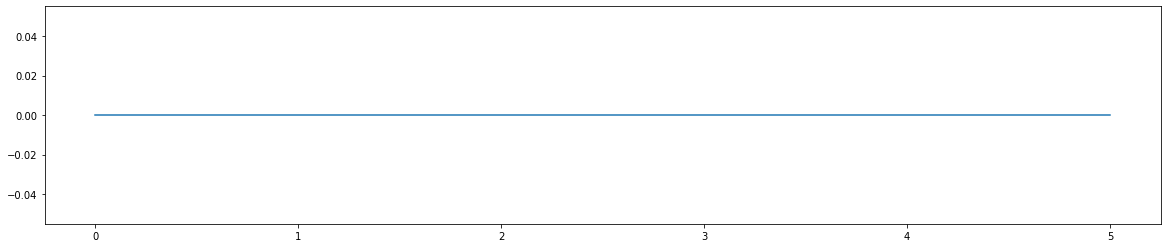

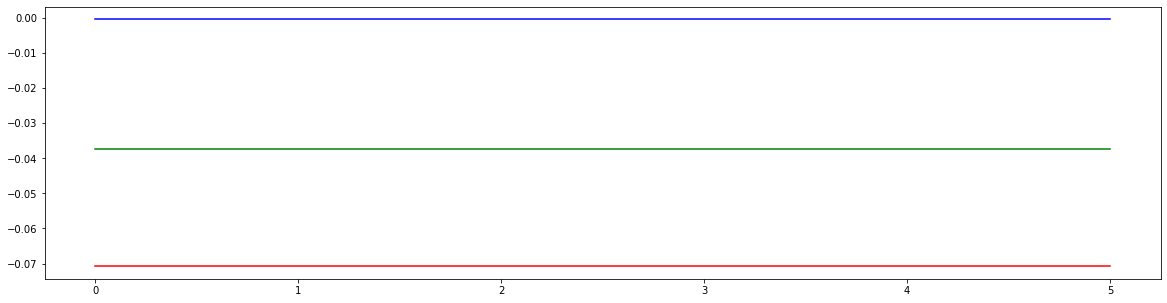

In [7]:
#plt.figure(figsize = (20,4))
#plt.bar([x for x in range(len(c_wins))],c_wins)
#plt.show()

plt.figure(figsize = (20,4))
plt.plot(wins)
plt.show()

plt.figure(figsize = (20,5))
plt.plot(x1,color="blue")
plt.plot(x2,color="red")
plt.plot(x3,color="green")

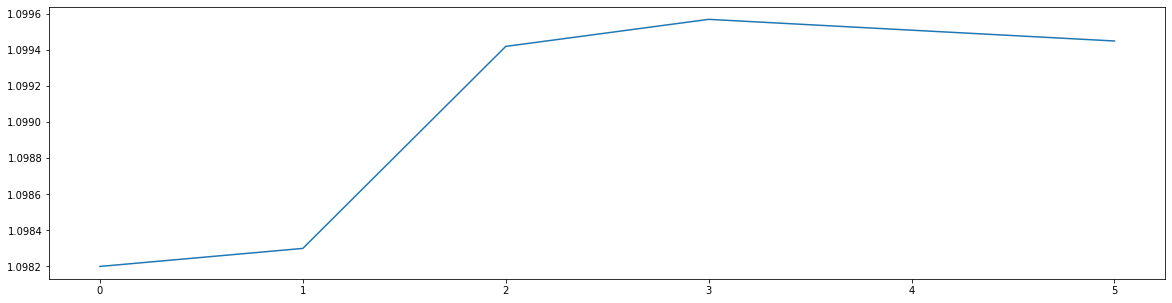

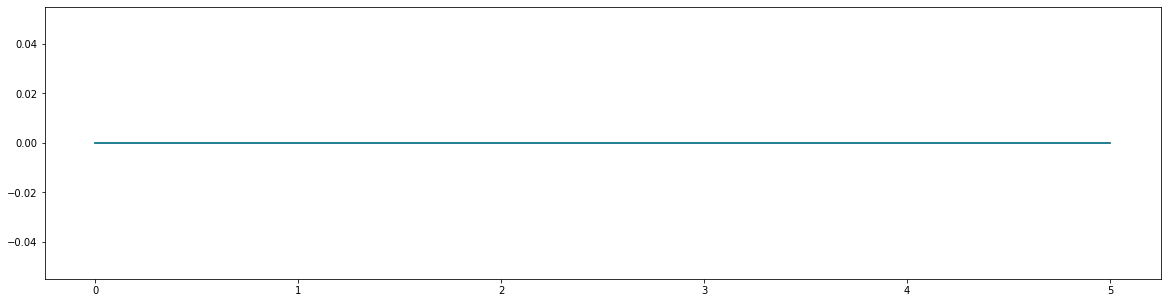

In [8]:
balance = []
balance_close_only = []
order_value = 1000
cbalance = 1000

plt.figure(figsize=(20,5))

position = 0
entry_price = 0
win = 0
current_win = 0

wins = []
def close():
        global position, win, current_win
        position = 0
        win+=current_win
        current_win = 0


for i in range(len(values)):
    c = candle_test[i].c
    h = candle_test[i].h
    l = candle_test[i].l
    o = candle_test[i].o
    
    #color = "red" if o > c else "green" if o < c else "blue"
    #plt.plot([i,i],[o,c],linewidth=3, color = color)
    #plt.plot([i,i],[l,h],linewidth=1, color = color)

    action  = values[i]
    
  
    if position != 0:
      current_price = c
      entry = entry_price
      diff = (current_price - entry) / entry * order_value

      if position == 1:
        current_win = diff
      if position == -1:
        current_win = -diff

    reward_raw = win + current_win
    wins.append(reward_raw)
    balance_close_only.append(win)
    
    if action == 0:
        if position != 0:
            close()
            plt.axvline(x = i, color="b")
        pass
    
    if action == 1:
      #short
      if position == 1:
        close()
        plt.axvline(x = i, color="b")

      if position == -1:
        pass
      else:
        position = -1
        entry_price = c
        win -= commission * order_value
        plt.axvline(x = i, color="r")
        
    if action == 2:
      #long
      if position == -1:
        close()
        plt.axvline(x = i, color="b")

      if position == 1:
        pass
      else:
        position = 1
        entry_price = c
        win -= commission * order_value
        plt.axvline(x = i, color="g")
        
    
plt.plot([c.c for c in candle_test])
plt.show()
    
plt.figure(figsize=(20,5))
plt.plot(balance_close_only, "g")
plt.plot(wins)

In [9]:
values2 = []
for i in values:
    if i == 0:
        values2.append(0)
    if i == 1:
        values2.append(2)
    if i == 2:
        values2.append(1)
        
values = values2

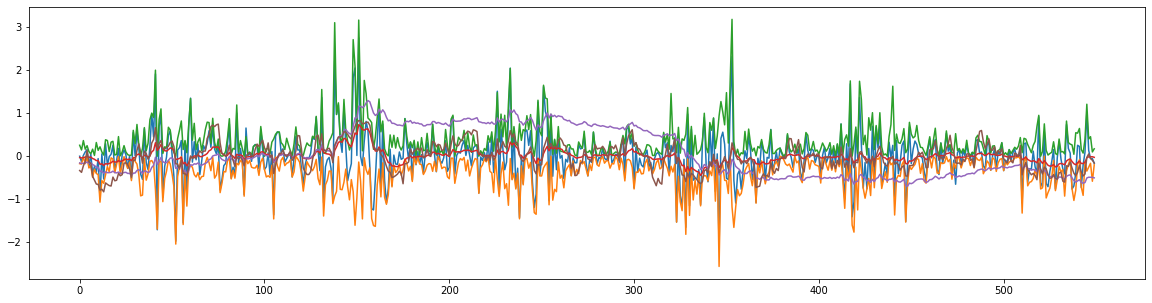

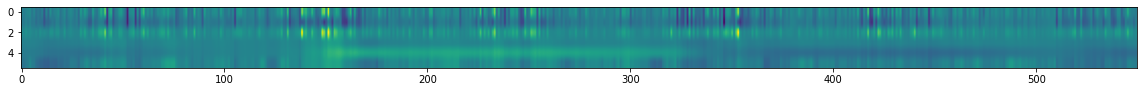

In [10]:
d = x.get_current_inference_data()
plt.figure(figsize = (20,5))

#xt = d.T
#xt[-1] = [0 for _ in range(seq_len)]
#d = xt.T

for i in d.T:
    plt.plot(i)
    
plt.show()
plt.figure(figsize = (20,5))
plt.imshow(d.T, aspect='5')
plt.show()

transformer_block_3
(550, 256)


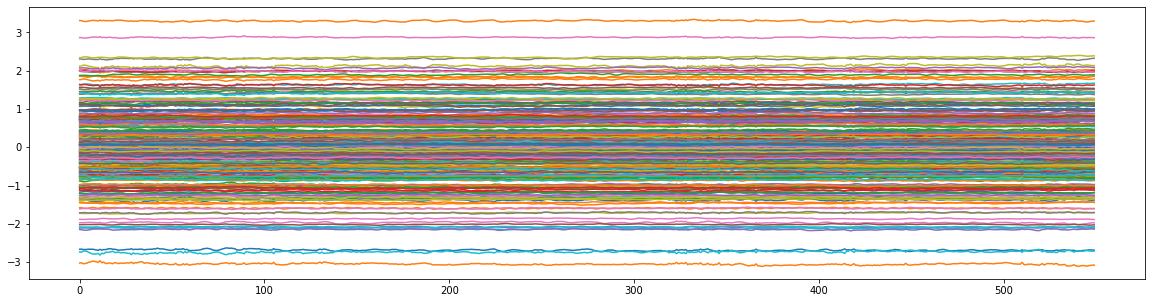

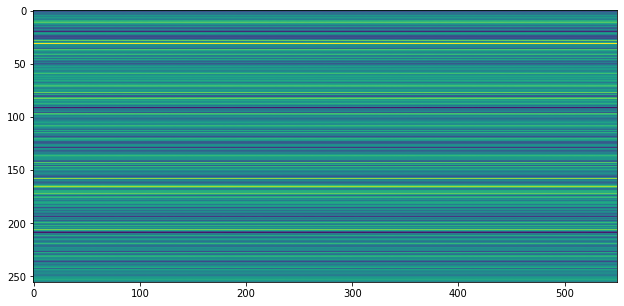

In [12]:
import cv2

feature_extractor = tf.keras.Model(inputs = model.inputs[0], outputs = model.layers[15].output)
#feature_extractor = tf.keras.Model(inputs = model.inputs[0], outputs = model.layers[17].output)
#feature_extractor.summary()
print(feature_extractor.layers[-1].name)
output = feature_extractor(d.reshape(1, seq_len, -1))
output = output[0].numpy()
print(output.shape)
plt.figure(figsize=(20,5))
for i in output.T:
    plt.plot(i)
plt.show()

plt.figure(figsize=(20,5))
#img = cv2.resize(output.T,(2000,500))
img = output.T
plt.imshow(img, aspect='1')
plt.show()